In [1]:
import os
import src

In [2]:
sheet = src.Sheet('samples/paraclis.pdf')

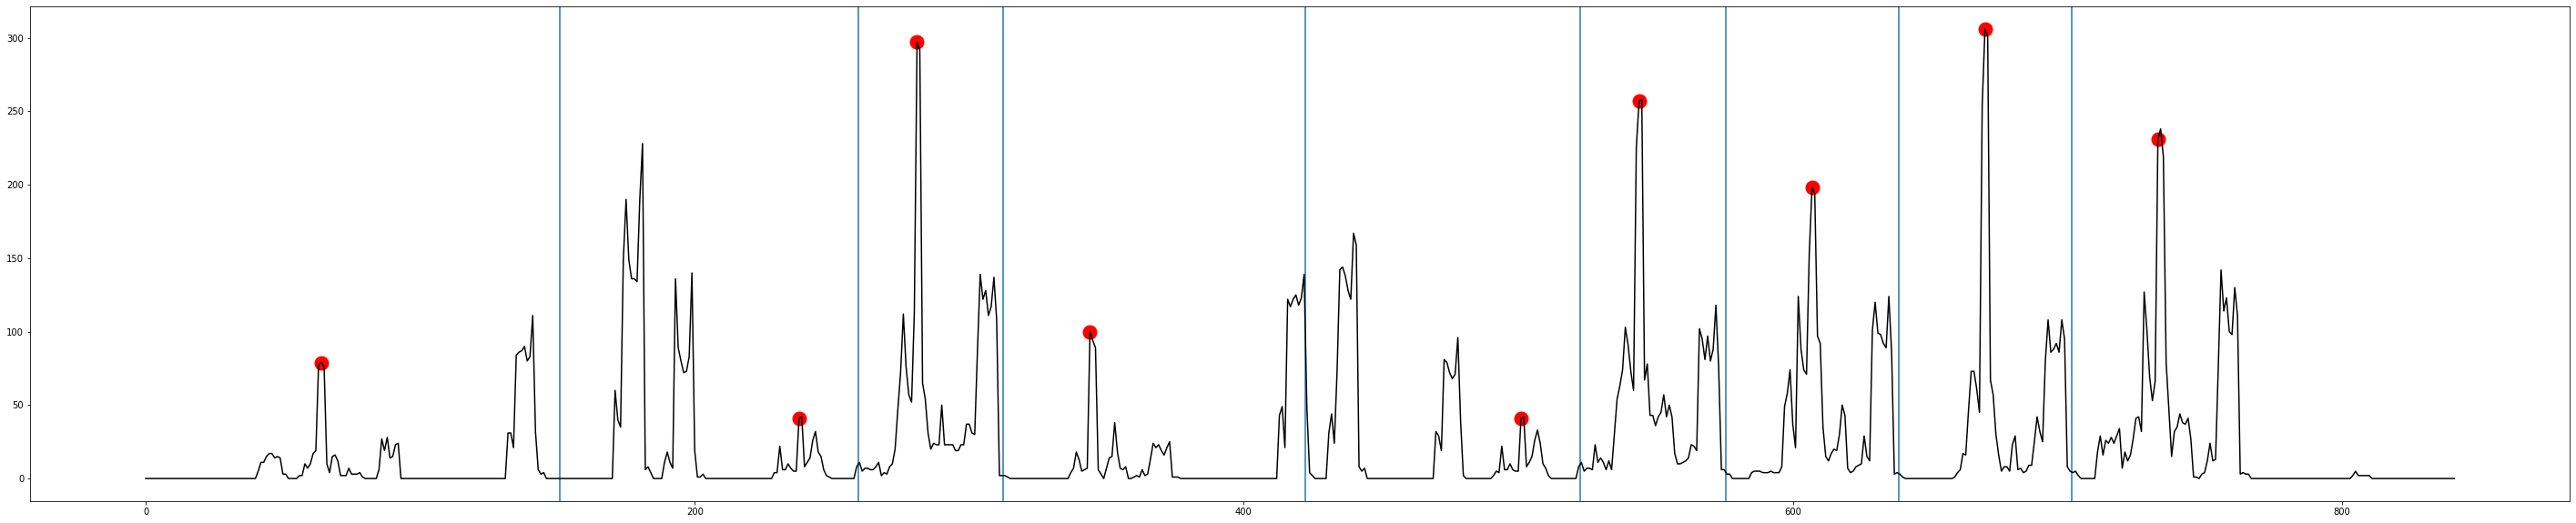

In [10]:
sheet[10].plot_raw_horizontal_projection()

['y = 64', 'y = 238', 'y = 281', 'y = 344', 'y = 501', 'y = 544', 'y = 607', 'y = 670', 'y = 733']
b1.y=64, b2.y=238, mid=151.0, max_peaks=[ 69  74  78  86  88  92 132 138 141 145], values=[ 16.   7.   4.  27.  28.  24.  31.  90. 111.   4.]
ind=[7 8]
max1=138, max2=141
b1.y=238, b2.y=281, mid=259.5, max_peaks=[244], values=[32.]


ValueError: kth(=-1) out of bounds (1)

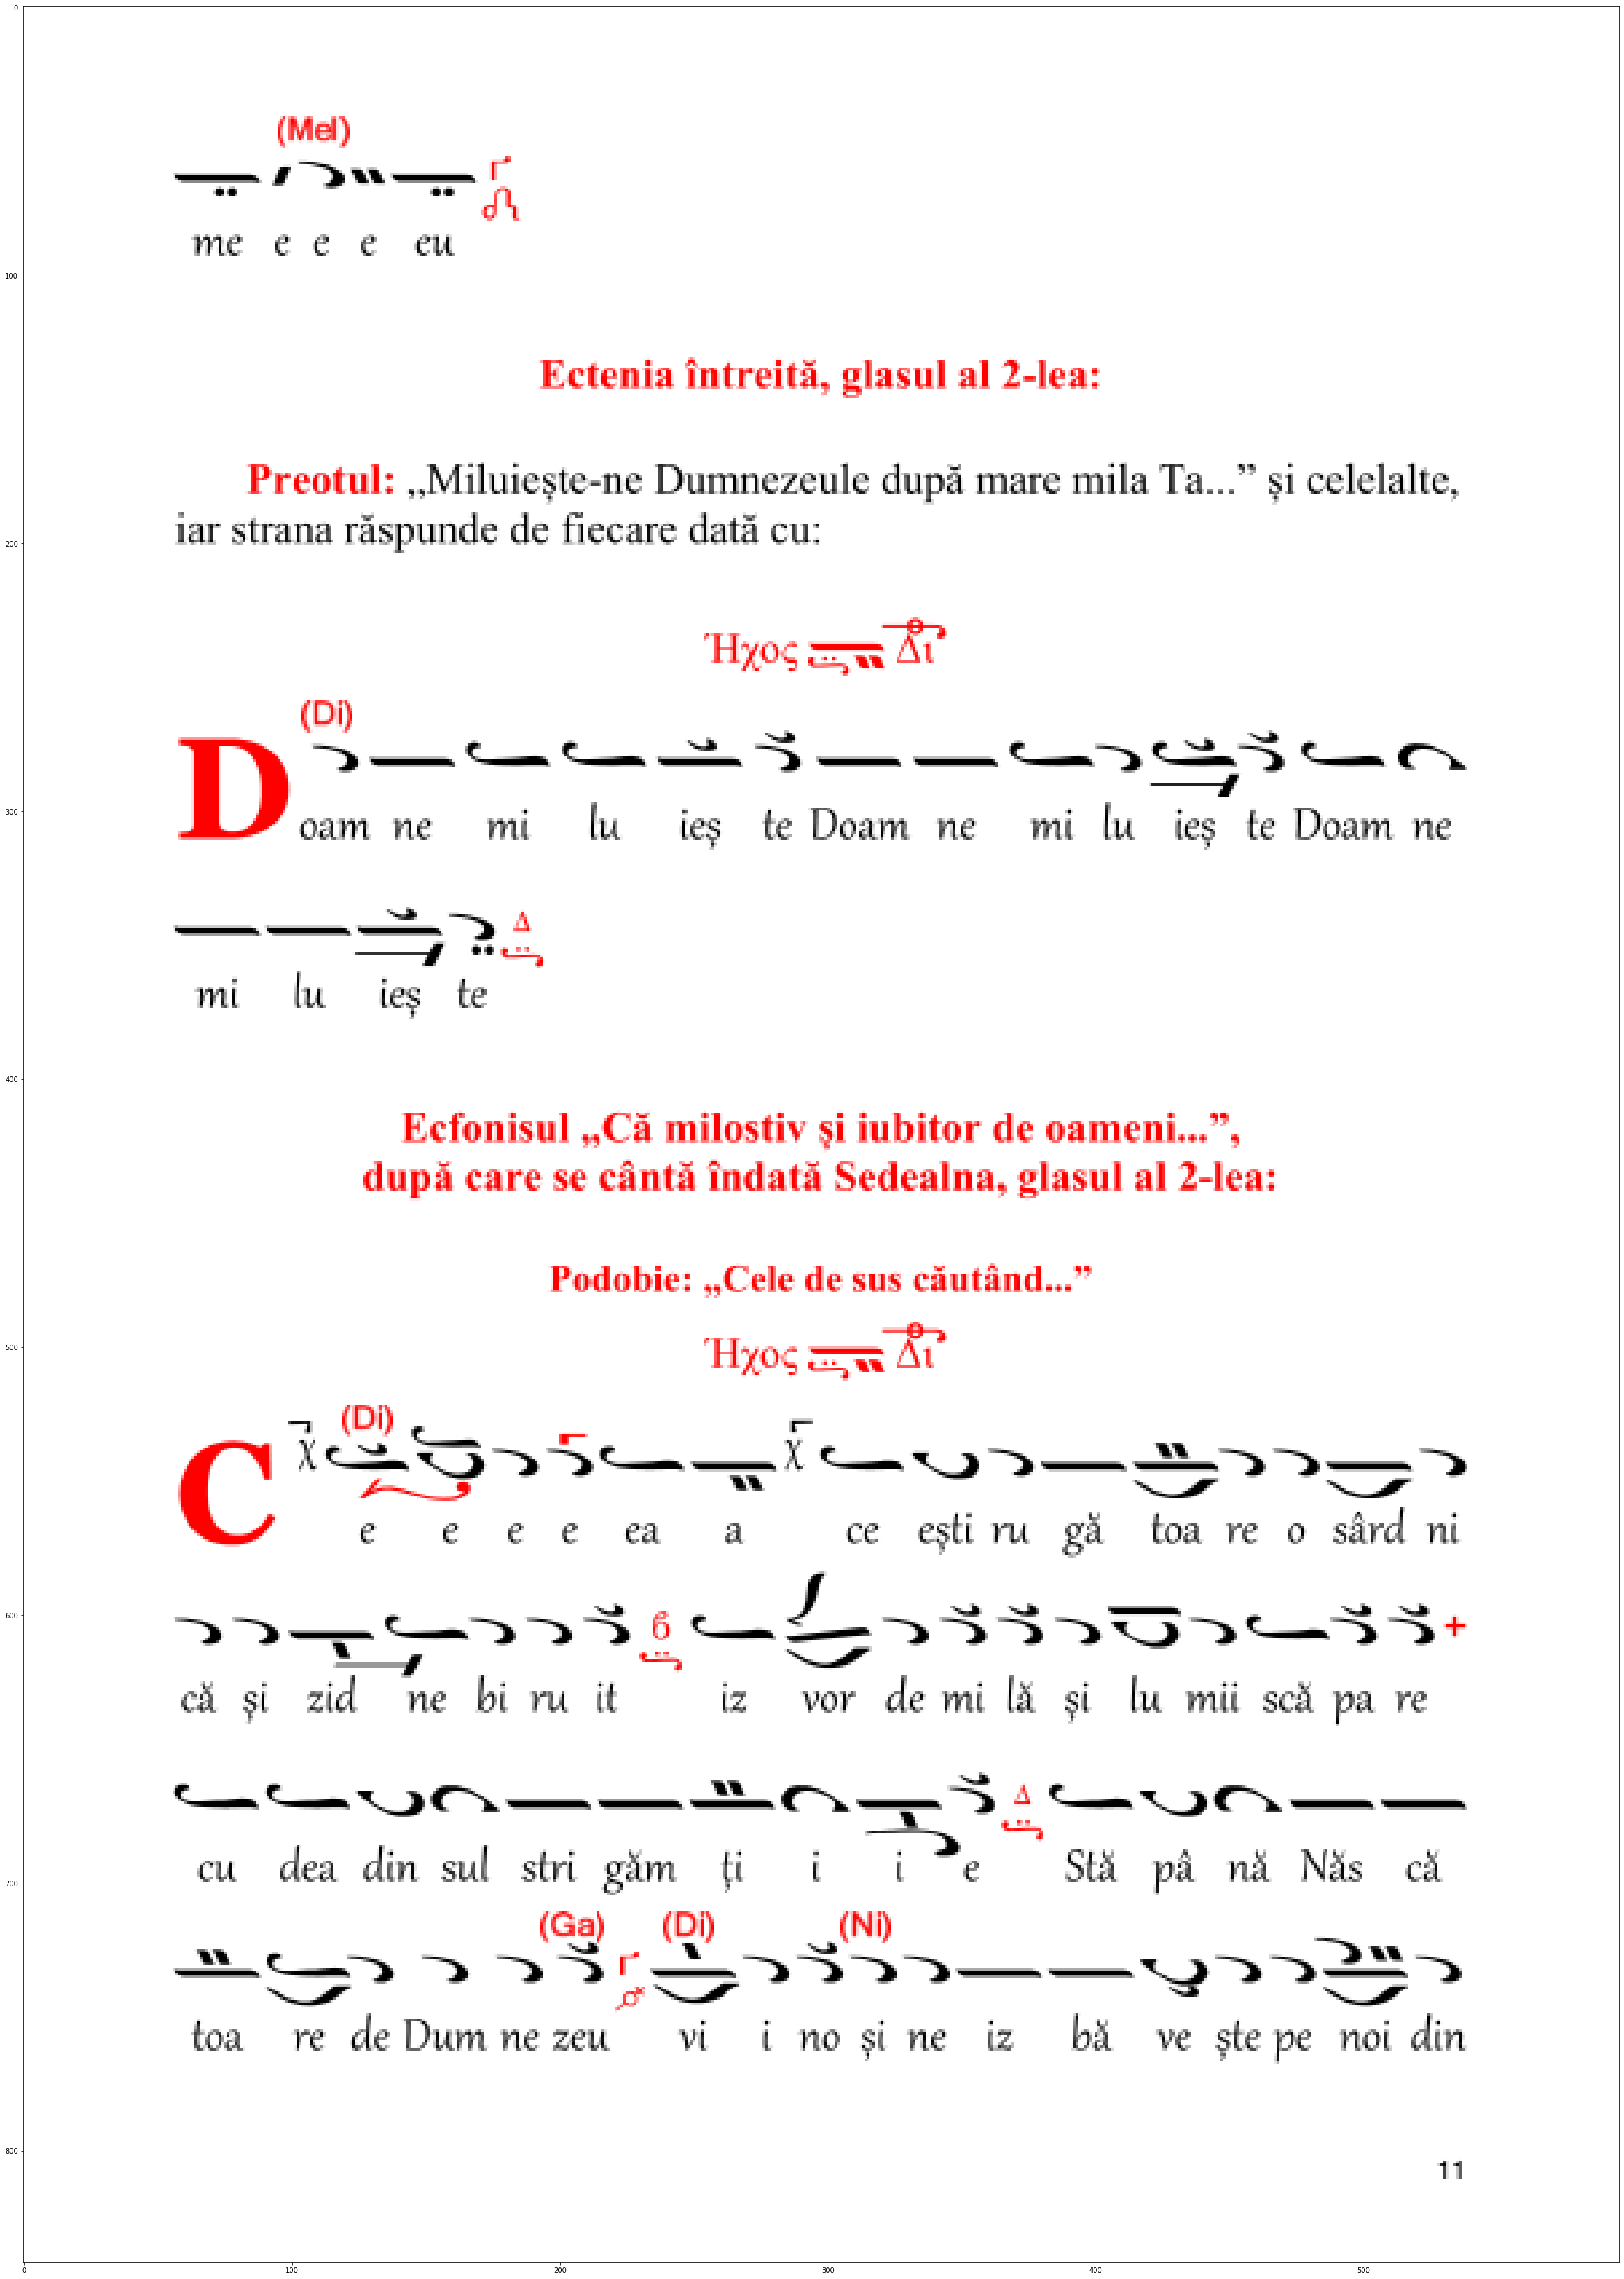

In [8]:
sheet[10].plot_full_baselines()

32


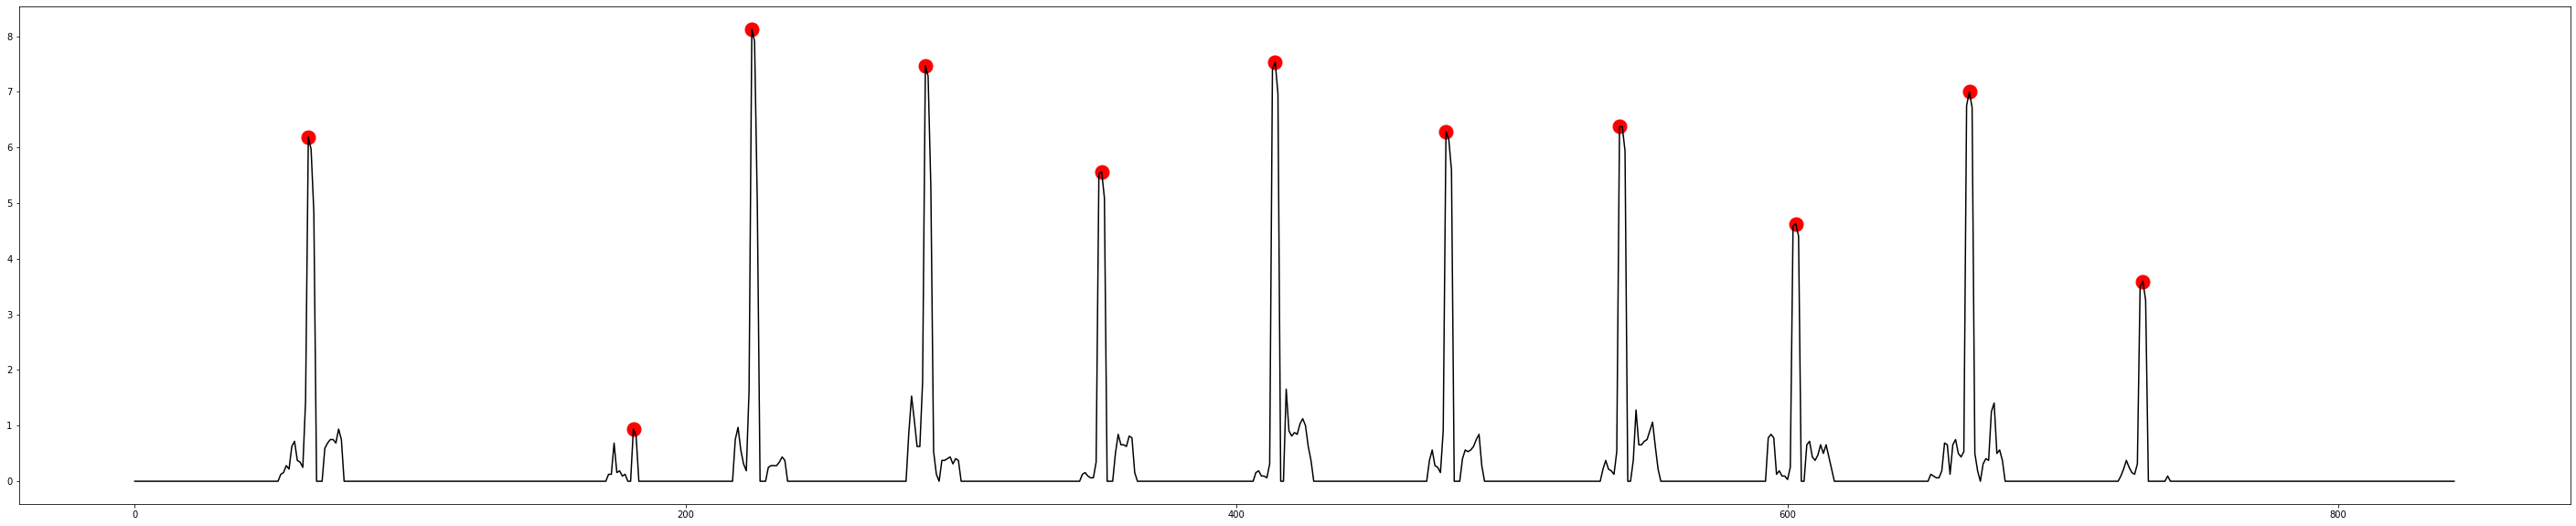

In [5]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

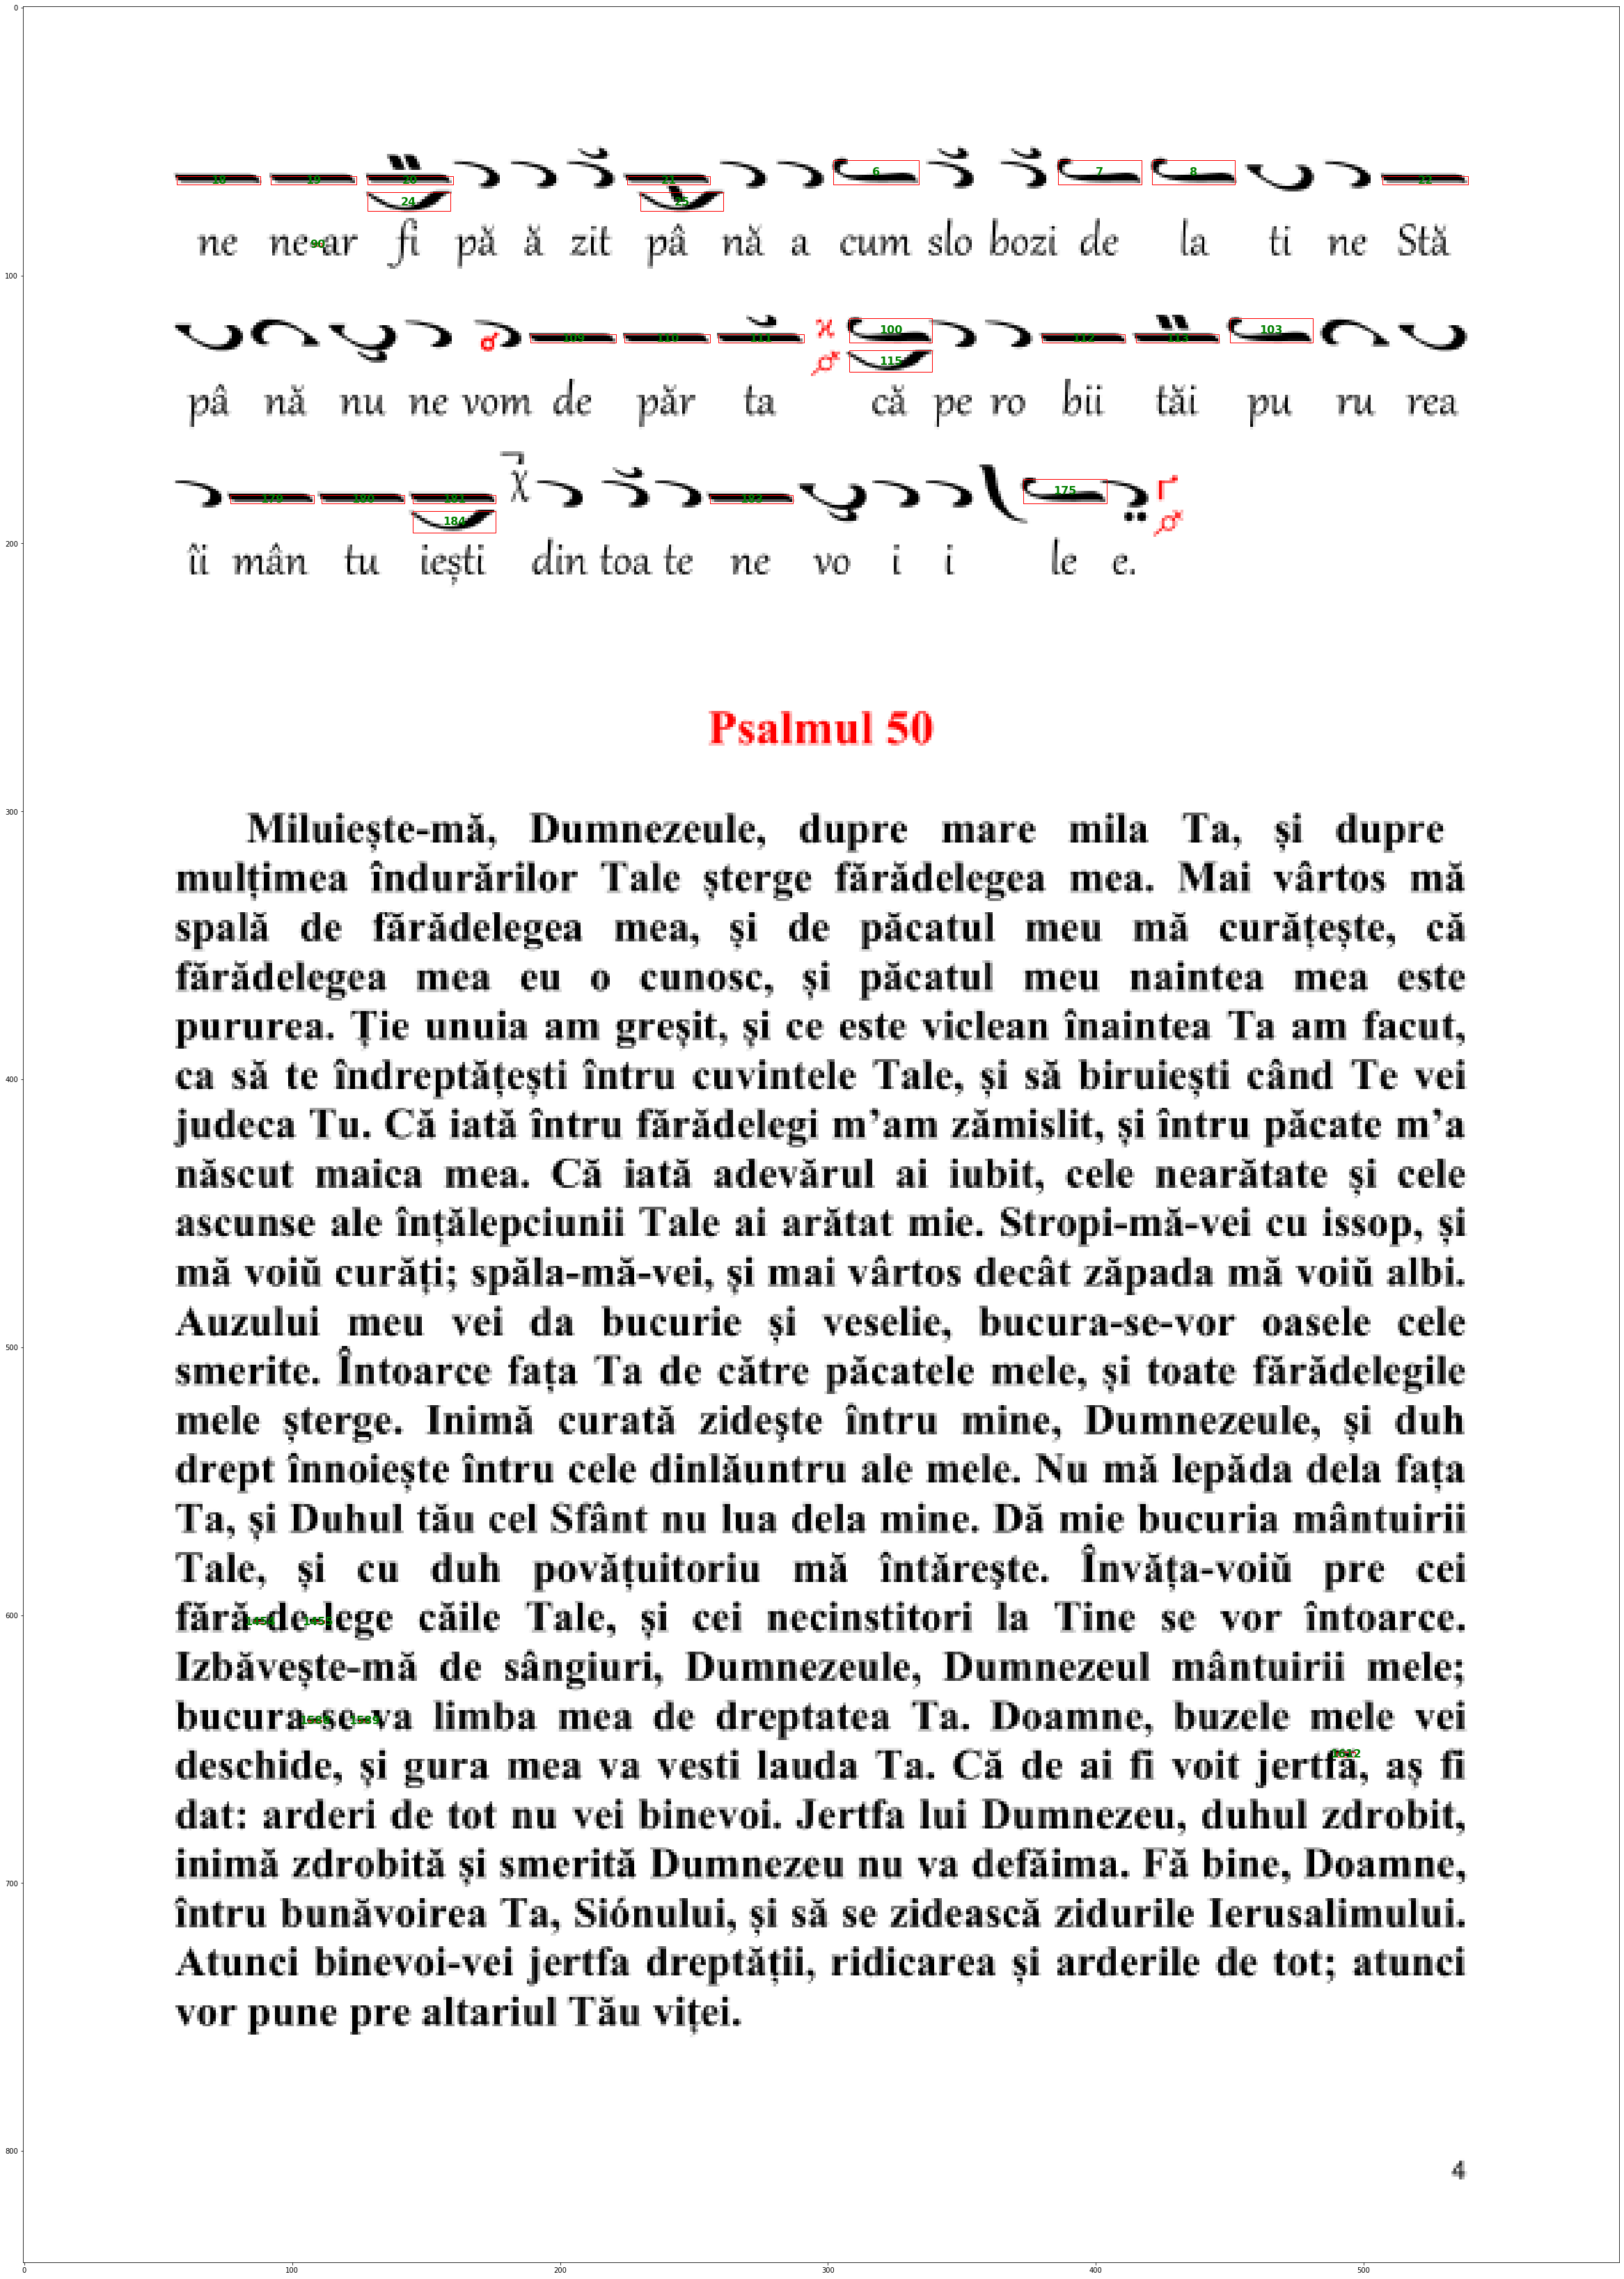

In [6]:
sheet[3].plot_ccs()